# PUI Final

# Goal: evaluate the relevance of different factors in causing asthma in NYC. 

## Motivation: 
Several environmental variables affect respiratory health. The health department finds correlation between asthma cases and a number of geographical factors, including:
proximity to highways, proximity to green spaces, criminality rate (murder rate specifically). Additionally environmental factors such as construction releasing air pollutants, unsanitary conditions, etc., may trigger respiratory problems.
In this work you will attempt to valuate the importance of these factors.

## Method: 

work on the ZIP code level.

1) __Identify the 5 facilities__ that reported the highest incidence of asthma cases and find which ZIP code they fall in.

2) __Develop a Metric__ for each of the fllowing: access to green space, murder rate, environmental health, and proximity to highways for each ZIP code (no panic, suggestions on how to proceed are in the hints file). You must choose AT LEAST 2 variables among these 4. We encourage you to work with three. Choosing 4 or more, and coming up with additional ones, is considered extra credit.

3) __Show a table__ containing the value of each variable of interest for the 5 ZIP codes corresponding to the highest cases of Asthma.

4) __Display__ each of your metrics as a choropleth (a heatmap version of a geographical map where each zip code is a different color based on the value of the metric you are mapping).

5) __Fit__ a model  (try a multivariable linear model for example or any other model which you think may be reasonable, keeping in mind you will need to use the model in the last task) to the incidence of asthma cases per NYC ZIP code (this is your dependent variable) as a function of variables mentioned above, based on the ZIP codes of the top 5 facilities reporing asthma. 

6) __Cluster__ the ZIP codes using the model you generated in step 4 as a distance metric (suggestions if needed are in the hints file).

7) __Discuss__. What did you find? What is the spatial coherence of the different factors considered, which variables seem to be more important in triggering asthma cases, what are the weaknesses of the model, how does the clustering look. 


<h1> Task 1: Querying Asthma Discharges </h1>

### 1. The list of the top 5 facilities by their facility names (aka. the facility_name column)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
%matplotlib inline

import ast
import json
import urllib
import urllib2
from cStringIO import StringIO
import pandas as pd
import geopandas as gpd

SQL_SOURCE = 'https://htv210.cartodb.com/api/v2/sql'

def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [3]:
dischargeQuery = '''
SELECT 
COUNT(facility_id) as count,
facility_id 
FROM nyc_discharge_2013

WHERE ccs_diagnosis_description ILIKE '%ASTHMA%'

GROUP BY facility_id
ORDER BY count DESC
'''
dischargeStream = queryCartoDB(dischargeQuery, format='CSV')
discharge       = pd.read_csv(dischargeStream)
discharge.head()

count  facility_id
0   1878         1172
1   1786         1169
2   1057         1301
3    920         1165
4    890         1178

In [4]:
facilityQuery = '''
SELECT *
FROM nyc_facilities

'''
facilityStream = queryCartoDB(facilityQuery, format='GeoJSON')
facilityData   = json.loads(facilityStream.read())
facilities     = gpd.GeoDataFrame.from_features(facilityData['features'])

In [5]:
# Get the information of top 5 facilities with asthma diagnose
five_facility = facilities[(facilities.facility_id).isin(discharge[:5].facility_id)].reset_index(drop=True)

In [6]:
# Get the information of all the facilities with asthma diagnose
asthma_facility = facilities[(facilities.facility_id).isin(discharge.facility_id)].reset_index(drop=True)

In [7]:
asthma_facility = pd.merge(asthma_facility, discharge, on = 'facility_id')

In [8]:
print five_facility.facility_name

0                                Jacobi Medical Center
1    Montefiore Medical Center - Henry & Lucy Moses...
2               Lincoln Medical & Mental Health Center
3    Bronx-Lebanon Hospital Center - Concourse Divi...
4                         Kings County Hospital Center
Name: facility_name, dtype: object


### 2. A map of those 5 facilities in the NAD 83 / New York Long Island (EPSG:2263) coordiantes.

In [9]:
import mplleaflet

In [10]:
def getXY(pt):
    return pt.x, pt.y

In [11]:
init_crs = {'init': 'epsg:4326', 'no_defs': True}
target_crs = {'init': 'epsg:2263', 'no_defs': True}

In [12]:
# Change the coordinate reference system of five_facility from WGS84 to NAD1983
five_facility.crs = init_crs
five_facility.to_crs(epsg=2263,inplace=True)

In [13]:
f, ax = plt.subplots(1, figsize=(10,10))
for i, facility in five_facility.iterrows():
    (point_x, point_y) = getXY(facility.geometry)
    ax.scatter(x=point_x, y=point_y,c='m', alpha=0.4, s=100)
mplleaflet.display(fig=f, crs=five_facility.crs)

<h2>Task 2: Geo-referencing the facilities with the zip code highway profile</h2>

### 1. A list of 5 facilities (like in Task 1.1) but with two additional columns: the ZIP code and the total highway miles belonging to that zip code.

In [14]:
zipcodeQuery = '''
SELECT *
FROM nyc_zipcode_highway
'''
zipcodeStream = queryCartoDB(zipcodeQuery, format='GeoJSON')
zipcodeData   = json.loads(zipcodeStream.read())
zipcodes      = gpd.GeoDataFrame.from_features(zipcodeData['features'])
zipcodes.head()

cartodb_id                                           geometry  \
0           1  (POLYGON ((-74.194287 40.608911, -74.194929 40...   
1           2  (POLYGON ((-73.980886 40.75927, -73.9804259999...   
2           3  (POLYGON ((-74.011674 40.709687, -74.012646 40...   
3           4  (POLYGON ((-73.97282 40.75587, -73.973276 40.7...   
4           5  (POLYGON ((-73.973735 40.754619, -73.975352 40...   

   highway_length  zipcode  
0       23.486470    10314  
1        0.000000    10112  
2        1.447405    10048  
3        0.000000    10171  
4        0.000000    10172

In [15]:
df = pd.DataFrame({'name':five_facility.facility_name,
                  'zipcode':five_facility.facility_zip_code,
                  'highway_length':((zipcodes[zipcodes.zipcode.isin(list(five_facility.facility_zip_code))].highway_length)).reset_index(drop=True)})
df

highway_length                                               name  zipcode
0       19.172015                              Jacobi Medical Center    10461
1        7.914185  Montefiore Medical Center - Henry & Lucy Moses...    10467
2        5.017199             Lincoln Medical & Mental Health Center    10451
3       18.102258  Bronx-Lebanon Hospital Center - Concourse Divi...    10457
4        2.212840                       Kings County Hospital Center    11203

### 2. A map (choropleth) of highway length for all NYC ZIP codes.

In [16]:
init_crs = {'init': 'epsg:4326', 'no_defs': True}
zipcodes.crs = init_crs
zipcodes.to_crs(epsg=2263, inplace=True)
zipcodes["centroid"] = zipcodes.geometry.centroid

In [17]:
zipcodes.head()

cartodb_id                                           geometry  \
0           1  (POLYGON ((930304.3783042837 161178.9118938052...   
1           2  (POLYGON ((989545.2338407208 215899.8262413288...   
2           3  (POLYGON ((981013.4939667572 197834.8189977061...   
3           4  (POLYGON ((991780.1768988252 214661.6858826231...   
4           5  (POLYGON ((991526.8142341244 214205.8286250296...   

   highway_length  zipcode                                     centroid  
0       23.486470    10314  POINT (939028.0863684642 157049.8160994551)  
1        0.000000    10112  POINT (989882.6299983194 215862.5539302718)  
2        1.447405    10048  POINT (980807.6977910449 198555.4211312696)  
3        0.000000    10171  POINT (991492.5078376996 214672.2913748862)  
4        0.000000    10172   POINT (991366.109232271 214444.1711985988)

(0.0, 1.0, 0.0, 1.0)

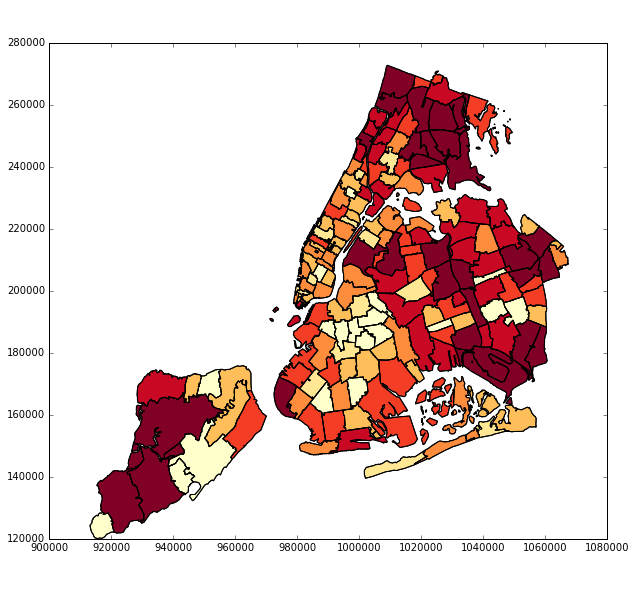

In [18]:
f, ax = plt.subplots(1, figsize=(10,10))
zipcodes.plot(column='highway_length', scheme='QUANTILES', k=7, alpha=1, colormap='YlOrRd')
ax.axis('off')

# TASK 4:
   Access to green space: find all information about size and location of NYC parks (see PUI2015_DATA.ipynb). Design an appropriate metric that describes the access to green spaces per zip code. This should take into account the size of nearby parks as well as the distance to them. Suggestions are given to you in the hints file.
   Your results should be: 
   <ol>
    <li> a dataframe like the one derived in TASK 3 but with an additional column: the access to park for the zip codes of the 5 identified facilities.</li>
    <li> choropleth of your 'access to green spaces metric' per for all ZIP codes in NYC</li>
   </ol>

In [19]:
park_data = gpd.GeoDataFrame.from_file(os.getenv ('PUI2015')+"/HW/final/data/DPR_ParksProperties_001/DPR_ParksProperties_001.shp")

In [20]:
park_data['centroid'] = park_data.geometry.centroid

In [21]:
f, ax = plt.subplots(1, figsize=(10,10))
for i, park in park_data.iterrows():
    (point_x, point_y) = getXY(park.geometry.centroid)
    ax.scatter(x=point_x, y=point_y,c='m', alpha=0.4, s=100)
zipcodes.plot()
mplleaflet.display(fig=f, crs=park_data.crs)

In [22]:
def getdistance(x1, y1, x2, y2):
    return(np.sqrt((x1-x2)**2+(y1-y2)**2))

In [23]:
zipcodes['park_access']=np.zeros(zipcodes.shape[0])

In [24]:
n = 20
for i,zipcode in zipcodes.iterrows():
    (zip_x, zip_y) = getXY(zipcode.geometry.centroid)
    near_parks = pd.Series(np.zeros(park_data.shape[0]))
    
    for j, park in park_data.iterrows():
        (park_x, park_y) = getXY(park.centroid)
        near_parks[j] = getdistance(park_x, park_y, zip_x, zip_y)

    near_parks_index = list(near_parks.sort_values()[:n].index)
    zipcodes['park_access'][i] = sum(park_data.iloc[near_parks_index].SHAPE_STAr/near_parks.sort_values()[:n])

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
df = pd.DataFrame({'name':five_facility.facility_name,
                  'zipcode':five_facility.facility_zip_code,
                  'highway_length':((zipcodes[zipcodes.zipcode.isin(list(five_facility.facility_zip_code))].highway_length)).reset_index(drop=True),
                  'park_access':((zipcodes[zipcodes.zipcode.isin(list(five_facility.facility_zip_code))].park_access)).reset_index(drop=True)})
df

highway_length                                               name  \
0       19.172015                              Jacobi Medical Center   
1        7.914185  Montefiore Medical Center - Henry & Lucy Moses...   
2        5.017199             Lincoln Medical & Mental Health Center   
3       18.102258  Bronx-Lebanon Hospital Center - Concourse Divi...   
4        2.212840                       Kings County Hospital Center   

   park_access  zipcode  
0  3570.809888    10461  
1  1688.043874    10467  
2  1010.593891    10451  
3  3199.048560    10457  
4   288.760980    11203

(0.0, 1.0, 0.0, 1.0)

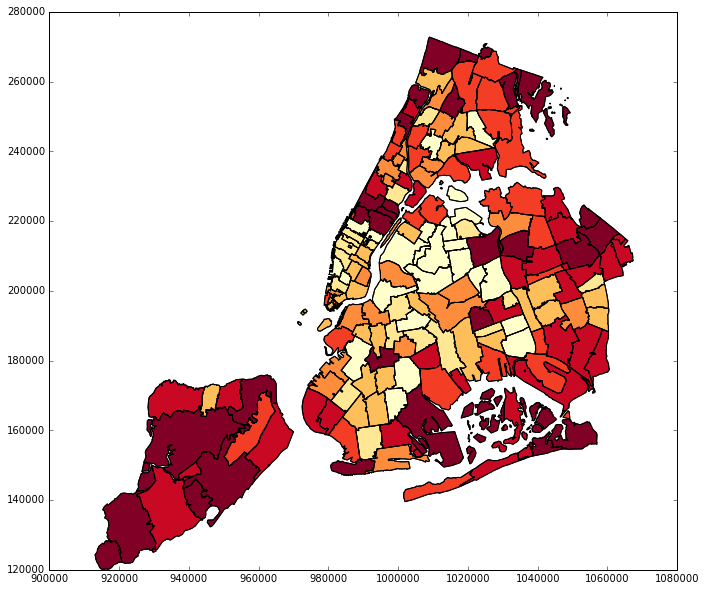

In [26]:
f, ax = plt.subplots(1, figsize=(12,10))
zipcodes.plot(column='park_access', scheme='QUANTILES', k=7, alpha=1, colormap='YlOrRd')
ax.axis('off')

# TASK 6:
  Create a regression model for the 5 zip codes that includes at least 2 of the variables (fewer than 2 will not allow a passing grade): 
  highway length in the zip code, exposure to violent crimes in that zip code, 
  access to green spaces in that zip code, 311-normalized calls in that zip code. 
        
  Report the statistics for your model and assess how well it describes the dependent variable.
    

In [27]:
asthma_group = asthma_facility.groupby('facility_zip_code')
zip_asthma = asthma_group.aggregate({'count':np.sum})
zip_asthma = pd.merge(zipcodes, zip_asthma, left_on='zipcode', right_index=True).reset_index(drop=True)
df = zip_asthma[zip_asthma.zipcode.isin(list(five_facility.facility_zip_code))]

In [28]:
df

cartodb_id                                           geometry  \
11         106  (POLYGON ((1022045.174324712 265485.8146390664...   
13         111  (POLYGON ((1003162.871453055 233644.226793992,...   
15         123  (POLYGON ((1012600.268767681 251224.6751115753...   
16         125  (POLYGON ((1032365.388388703 243251.7094464547...   
34         195  (POLYGON ((1000207.410375923 172073.7932331467...   

    highway_length  zipcode                                     centroid  \
11       19.172015    10467  POINT (1019634.113384963 259154.6803328866)   
13        7.914185    10451   POINT (1005358.281262738 238416.559446114)   
15        5.017199    10457  POINT (1012366.831063455 247764.7190462862)   
16       18.102258    10461  POINT (1028271.018093464 247827.9779312137)   
34        2.212840    11203   POINT (1002454.371100174 175881.143019862)   

    park_access  count  
11  3570.809888   1996  
13  1688.043874   1878  
15  1010.593891   1580  
16  3199.048560   1343  
34   288.760980   1780

In [29]:
import statsmodels.formula.api as smf

In [30]:
lm = smf.ols("count~highway_length+park_access", df).fit()

In [31]:
print lm.summary()

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                 -0.486
Method:                 Least Squares   F-statistic:                    0.3457
Date:                Tue, 22 Dec 2015   Prob (F-statistic):              0.743
Time:                        13:24:47   Log-Likelihood:                -33.560
No. Observations:                   5   AIC:                             73.12
Df Residuals:                       2   BIC:                             71.95
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept       1695.4924    262.024      6.

/usr/local/lib/python2.7/site-packages/statsmodels-0.6.1-py2.7-macosx-10.10-x86_64.egg/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n))


From the summary above we can find out that highway_length and park_access are not significant at the level of 0.05, and the R-square is 0.257

# TASK 7:
   Use the elements of this model to cluster NYC zip codes by asthma risk. Your distance metric cna be bilt on the result of the regression. See Hints file if you need help on this task
   
   The result will be a map of the clusters.

In [32]:
from sklearn.cluster import KMeans

In [33]:
lm.params

Intercept         1695.492409
highway_length    -158.605267
park_access          0.862270
dtype: float64

In [34]:
def euclid_dist(i,j):
    return(np.sqrt(np.sum((i-j)**2)))

In [35]:
x = zip_asthma[['highway_length','park_access','count']].reset_index(drop=True)
x['highway_length'] = x['highway_length']*lm.params[1]
x['park_access'] = x['park_access']*lm.params[2]

In [36]:
km = KMeans(n_clusters=3)
km.fit(x)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [37]:
zip_asthma['labels']=km.labels_

In [38]:
zip_asthma.head()

cartodb_id                                           geometry  \
0          17  (POLYGON ((954812.9817938869 173205.956084427,...   
1          29  (POLYGON ((1002515.19766016 191891.2358232759,...   
2          40  (POLYGON ((990508.4373542365 220369.6933363593...   
3          41  (POLYGON ((997702.9518395039 221099.0967237492...   
4          52  (POLYGON ((1046346.295127144 158697.9792630884...   

   highway_length  zipcode                                     centroid  \
0        0.000000    10310  POINT (951924.9178682701 169740.4799985407)   
1        1.416299    11206  POINT (1000208.664588381 195052.7367717527)   
2        2.108747    10019  POINT (988521.4615143476 218414.6454932473)   
3        4.232831    10021  POINT (994735.0101640197 219641.2760085364)   
4        3.422208    11691  POINT (1047117.494477257 160273.8609665282)   

    park_access  count  labels  
0   5037.782018    404       1  
1    492.357155    486       0  
2    338.195119    289       0  
3   8152.287323    562       1  
4  11739.692156    224       2

In [39]:
zip_cluster = pd.merge(zipcodes,zip_asthma.drop(['geometry','count','cartodb_id','highway_length','centroid','park_access'],axis=1), 
                       on='zipcode')

In [40]:
zip_cluster.head()

cartodb_id                                           geometry  \
0          17  (POLYGON ((954812.9817938869 173205.956084427,...   
1          29  (POLYGON ((1002515.19766016 191891.2358232759,...   
2          40  (POLYGON ((990508.4373542365 220369.6933363593...   
3          41  (POLYGON ((997702.9518395039 221099.0967237492...   
4          52  (POLYGON ((1046346.295127144 158697.9792630884...   

   highway_length  zipcode                                     centroid  \
0        0.000000    10310  POINT (951924.9178682701 169740.4799985407)   
1        1.416299    11206  POINT (1000208.664588381 195052.7367717527)   
2        2.108747    10019  POINT (988521.4615143476 218414.6454932473)   
3        4.232831    10021  POINT (994735.0101640197 219641.2760085364)   
4        3.422208    11691  POINT (1047117.494477257 160273.8609665282)   

    park_access  labels  
0   5037.782018       1  
1    492.357155       0  
2    338.195119       0  
3   8152.287323       1  
4  11739.692156       2

(0.0, 1.0, 0.0, 1.0)

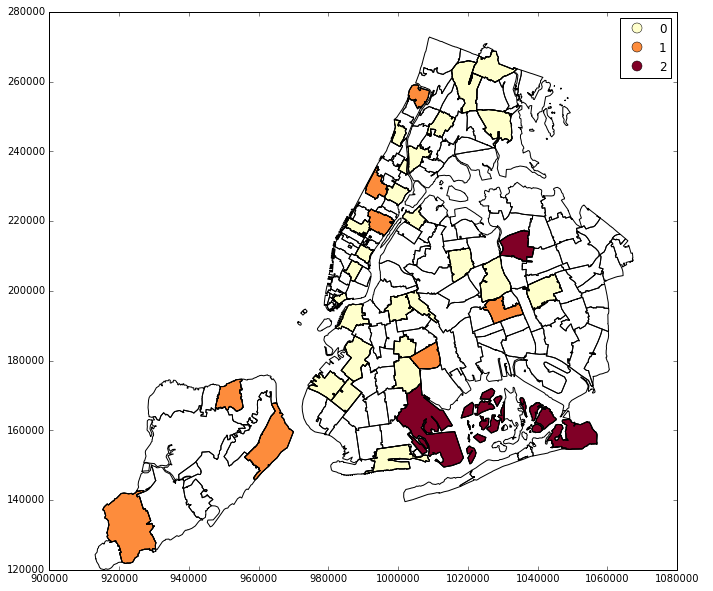

In [41]:
f, ax = plt.subplots(1, figsize=(12,10))
zip_cluster.plot(column='labels', k=7, alpha=1, colormap='YlOrRd',legend=True, categorical=True)
zipcodes.plot(alpha=0)
ax.axis('off')